# Training set exploration

In [1]:
from os.path import isfile, isdir, join
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import collections

IN_BRAT_DIR = '../../data/release/train2021/'
#IN_TRAIN_FILE = '../../data/work/classes-train-train.txt'
IN_TRAIN_FILE = '../../data/release/classes-train-v2.txt'

assert isdir(IN_BRAT_DIR)
assert isfile(IN_TRAIN_FILE)

In [10]:
FR_EN_MAPPING = {
    'infections':'infections',
    "virales":"viral",
    "parasitaires":"parasitic",
    "tumeur":"tumors",
    'osteomusculaires':'musculoskeletal',
    'digestif':'digestive',
    'stomatognathique':'stomathognathic',
    'respiratoire':'respiratory',
    'ORL':'ENT',
    'nerveux':'nervous',
    'oeil':'eye',
    'homme':'male_uro',
    'femme':'female_uro',
    'cardiovasculaires':'cardiovascular',
    "hemopathies":"hemic",
    'genetique':'congenital',
    'peau':'skin',
    'nutritionnelles':'nutritional',
    'endocriniennes':'endocrine',
    'immunitaire':'immune',
    'etatsosy':'path_sosy',
    'chimiques':'chemical',
    'blessures':'injuries'
}

In [12]:
labels_df = pd.read_csv(IN_TRAIN_FILE, sep='\t', header=None, names=['file', 'label', 'desc'])

labels = set(labels_df['label'].unique())

files = labels_df['file'].unique()


In [18]:
labels_df['label_en'] = labels_df['label'].apply(lambda x : FR_EN_MAPPING[x])

### labels

## Label distribution

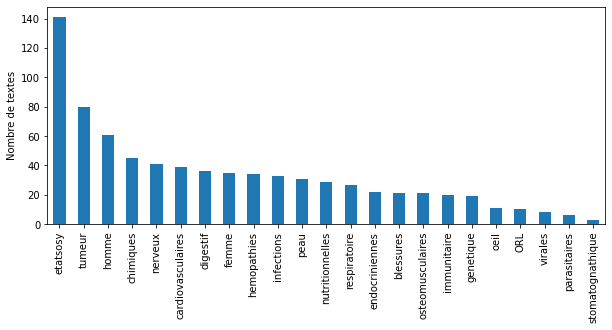

In [13]:
ax = labels_df['label'].value_counts().plot(kind='bar',
                                    figsize=(10,4),
                                    title="") #Nombre de textes par label")
ax.set_xlabel("")
ax.set_ylabel("Nombre de textes")
plt.savefig('label_stats1.png', bbox_inches='tight', dpi=300)

With the xticks above

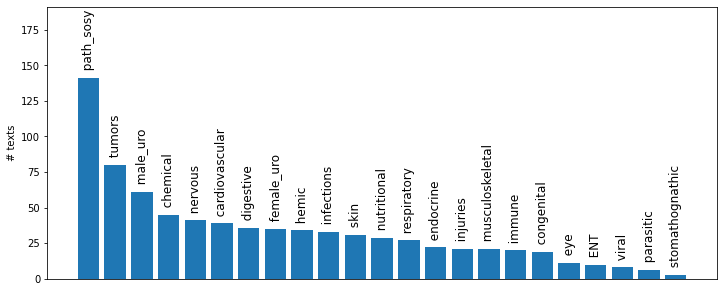

In [22]:
x = np.array(labels_df['label_en'].value_counts().keys())
y = np.array(labels_df['label_en'].value_counts())

fig, ax = plt.subplots(figsize=(12, 5))

# Remove xticks
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax.set_ylim([0,y.max() + 50])
ax.set_ylabel("# texts")

bars = ax.bar(x, y)

def autolabel(rects, x):
    """
    Attach a text label above each bar displaying its height
    """
    for i, rect in enumerate(rects):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1*height,
                "  " + x[i], rotation="vertical",
                fontsize='large',
                ha='center', va='bottom')
autolabel(bars, x)
plt.savefig('label_stats1.png', bbox_inches='tight', dpi=600)
#plt.show()

array(['etatsosy', 'tumeur', 'homme', 'chimiques', 'nerveux',
       'cardiovasculaires', 'digestif', 'femme', 'hemopathies',
       'infections', 'peau', 'nutritionnelles', 'respiratoire',
       'endocriniennes', 'blessures', 'osteomusculaires', 'immunitaire',
       'genetique', 'oeil', 'ORL', 'virales', 'parasitaires',
       'stomatognathique'], dtype=object)

## Number of labels per document

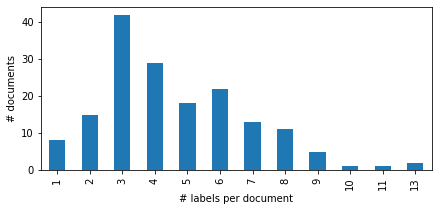

In [25]:
ax = labels_df['file'].value_counts().value_counts(sort=False).plot(kind='bar',
                                    figsize=(7,3),
                                    title="") #Nombre de labels par documents")
ax.set_xlabel("# labels per document")
ax.set_ylabel("# documents")
plt.savefig('label_stats2.png', bbox_inches='tight', dpi=600)

## What are the NER tags of the spans labeled with Mesh codes?

In [7]:
def find_offsets_relaxed_match(label_infos, left_offset, right_offset):
    matches = []
    for o in label_infos.keys():
        o_list = o.split(' ')
        leftmost_offset = int(o_list[0])
        rightmost_offset = int(o_list[-1])
        if leftmost_offset <= left_offset <= rightmost_offset or leftmost_offset <= right_offset <= rightmost_offset or left_offset <= leftmost_offset <= right_offset or left_offset <= rightmost_offset <= right_offset:
            matches.append((o, label_infos[o]))
    return matches
        

In [8]:
ENTITY_REGEX = re.compile('^(T\d+)\t([^ ]+) ([^\t]+)\t(.*)$')

tags = []

for ann_file in files:
    #if '-24-' not in ann_file:
    #    continue
    ann_path = join(IN_BRAT_DIR, ann_file)
    txt_path = join(IN_BRAT_DIR, ann_file[:-4] + ".txt")
    assert isfile(ann_path)
    assert isfile(txt_path)
    # Read ann file
    with open(ann_path, 'r', encoding='utf-8') as f_in:
        lines = f_in.readlines()
    # Read corresponding txt file
    text = open(txt_path, 'r', encoding='utf-8').read()
        
    # First pass -> extract all labels (i.e entity with Mesh-like tags)
    label_infos = {}
    other_infos = {}
    for line in lines:
        entity_match = ENTITY_REGEX.match(line.strip())
        if entity_match is not None:
            ann_id = entity_match.group(1)
            label = entity_match.group(2)
            offsets = entity_match.group(3)
            span = entity_match.group(4)
            if label in labels:
                label_list = label_infos.get(offsets, [])
                label_list.append((ann_id, label, offsets, span))
                label_infos[offsets] = label_list

    # Find other mentions with the same offsets
    for line in lines:
        entity_match = ENTITY_REGEX.match(line.strip())
        if entity_match is not None:
            ann_id = entity_match.group(1)
            label = entity_match.group(2)
            offsets = entity_match.group(3)
            offset_list = offsets.split(' ')
            leftmost_offset = int(offset_list[0])
            rightmost_offset = int(offset_list[-1])
            span = text[leftmost_offset:rightmost_offset]
            left = text[max(leftmost_offset - 60, 0):leftmost_offset].replace('\n', ' ')
            right = text[rightmost_offset:min(rightmost_offset + 30, len(text))].replace('\n', ' ')
            if label not in labels:
                # restrict to pathology and sosy
                if label in ('pathologie', 'sosy'):
                    res = find_offsets_relaxed_match(label_infos, leftmost_offset, rightmost_offset)
                    if len(res):
                        for r in res:
                            new_offsets, mesh_tags = r
                            mesh_tags = ', '.join([i[1] for i in mesh_tags])
                            tags.append([ann_file, ann_id, new_offsets, left, span, right, label, mesh_tags])
                    else:
                        tags.append([ann_file, ann_id, offsets, left, span, right, label, None])

    for offsets in label_infos.keys():
        offset_df = [t for t in tags if t[2] == offsets]
        if not len(offset_df):
            offset_list = offsets.split(' ')
            leftmost_offset = int(offset_list[0])
            rightmost_offset = int(offset_list[-1])
            span = text[leftmost_offset:rightmost_offset]
            left = text[max(leftmost_offset - 60, 0):leftmost_offset]
            right = text[rightmost_offset:min(rightmost_offset + 30, len(text))]
            tags.append([ann_file, ann_id, offsets, left, span, right, 'null', ', '.join([i[1] for i in label_infos[offsets]])])
    
tag_df = pd.DataFrame(data=tags, columns=['ann_file', 'ann_id', 'offsets', 'left', 'span','right', 'label', 'tag'])

In [9]:
tag_df

,ann_file,ann_id,offsets,left,span,right,label,tag
0,filehtml-146-cas.ann,T1004,122 133,ystéroscopie et une myomectomie chez une patie...,épileptique,. Le geste est réalisé avec l,pathologie,nerveux
1,filehtml-146-cas.ann,T200192,1174 1191,'y a eu aucune conséquence pour la patiente en...,légère somnolence,.,sosy,etatsosy
2,filehtml-146-cas.ann,T20017,686 701,morphine de 10mg au lieu de 1 mg. La patient...,10 fois la dose,nécessaire (1mg au lieu de 0.,sosy,chimiques
3,filehtml-146-cas.ann,T20024,1129 1140,mettre en œuvre le protocole NALOXONE. Il n'...,conséquence,pour la patiente en dehors d',sosy,None
4,filehtml-24-cas.ann,T1,95 107,rigine ghanéenne enceinte de 14 semaines. Elle...,vomissements,depuis le début de sa grosses,sosy,etatsosy
...,...,...,...,...,...,...,...,...
3365,filepdf-98-2-cas.ann,T2009,389 431,marquée des conjonctives et une hématurie avec...,reste de l’examen était sans particularité,. Les examens biologiques retr,sosy,None
3366,filepdf-98-2-cas.ann,T20010,518 566,etrouvaient une anémie ferriprive (hémoglobine...,ionogramme sanguin et un bilan hépatique normaux,. Une échographie mettait en é,sosy,None
3367,filepdf-98-2-cas.ann,T2003,1313 1319,ale de vessie fut réalisée mais compte tenu du...,tumeur,", celle-ci fut incomplète. L’e",sosy,tumeur
3368,filepdf-98-2-cas.ann,T20021,1449 1464,une tumeur fibromyxoïde de la vessie (Figure ...,caractère bénin,", au volume tumoral et à une s",sosy,None


### Tags of the spans that ARE labeled with a Mesh code

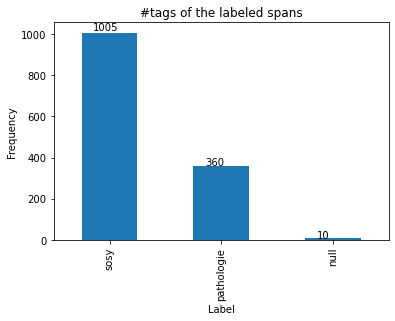

In [10]:
ax = tag_df[tag_df['tag'].notnull()]['label'].value_counts().plot(kind='bar',
                                    #figsize=(14,8),
                                    title="#tags of the labeled spans")
ax.set_xlabel("Label")
ax.set_ylabel("Frequency")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (0.1+(p.get_x() * 1.005), p.get_height() * 1.01))



### A few examples of spans that ARE labeled with a Mesh code

In [11]:
n = 10

for tag in tag_df[tag_df['tag'].notnull()]['label'].unique():
    if tag == 'null':
        continue
    print(f'-----------------------------\n{tag}\n-----------------------------')
    sample = tag_df[(tag_df['tag'].notnull()) & (tag_df['label'] == tag)].sample(n, replace=True)
    for _, raw in sample.iterrows():
        print('...{3:>60} | {4} [{5}] | {6} [{0}-{1}({2})]'.format(raw['ann_file'], raw['ann_id'], raw['offsets'], raw['left'], raw['span'], raw['tag'], raw['right']))

    

-----------------------------
pathologie
-----------------------------
... des doigts de près OD et 1/10 OG, l’examen du FO montre un  | œdème papillaire de stase bilatérale [nerveux, oeil] |  et un angiome rétinien typiqu [filepdf-828-cas.ann-T16(257 273)]
... bronchique. Une ponction biopsie de la masse a conclu à un  | synovialosarcome [tumeur] | . Une intervention chirurgical [filepdf-854-cas.ann-T10027(1151 1167)]
...cholestérolémie secondaire à la prise d’isotrétinoïne et de  | myopie [oeil] |  nécessitant le port de verres [filepdf-732-cas.ann-T18(1070 1076)]
...ême le duodénum et l’estomac et un cadre colique plat.  Une  | périhépatite intense ferme [infections, digestif] |  complète l’espace interhépato [filepdf-806-cas.ann-T10026(1357 1383)]
...re notable. Son tracé électrocardiogramme (ECG) montrait un  | aspect douteux type 2 du syndrome de Brugada [cardiovasculaires, genetique] |  (figure 1). Le tracé ECG perm [filepdf-698-cas.ann-T20(251 270)]
...ents chirurgicaux. En mai

### Tags of the spans that ARE NOT labeled with a Mesh code

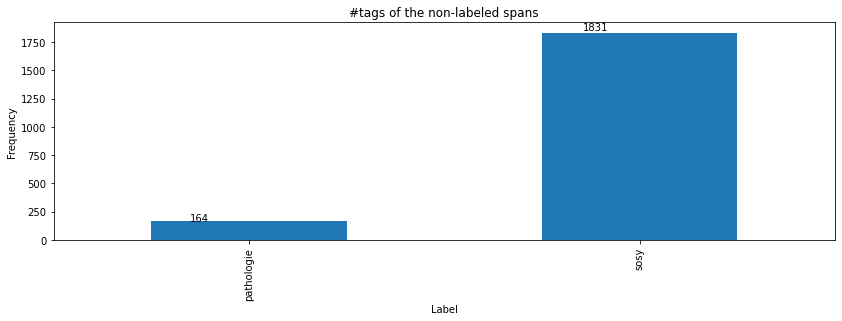

In [12]:
ax = tag_df[tag_df['tag'].isnull()]['label'].value_counts(sort=False).plot(kind='bar',
                                    figsize=(14,4),
                                    title="#tags of the non-labeled spans")
ax.set_xlabel("Label")
ax.set_ylabel("Frequency")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (0.1+(p.get_x() * 1.005), p.get_height() * 1.01))



### A few examples of spans that ARE NOT labeled with a Mesh code

In [13]:
n = 20

for tag in tag_df[tag_df['tag'].notnull()]['label'].unique():
    if tag == 'null':
        continue
    print(f'-----------------------------\n{tag}\n-----------------------------')
    sample = tag_df[(tag_df['tag'].isnull()) & (tag_df['label'] == tag)].sample(n, replace=True)
    for _, raw in sample.iterrows():
        print('...{3:>60} | {4} [{5}] | {6} [{0}-{1}({2})]'.format(raw['ann_file'], raw['ann_id'], raw['offsets'], raw['left'], raw['span'], raw['tag'], raw['right']))


-----------------------------
pathologie
-----------------------------
...=1,15N à prédominance conjugué. Les sérologies virales de l’ | hépatite B et C [None] |  ainsi que les marqueurs immun [filepdf-825-cas.ann-T75(1603 1618)]
...s après l’intervention, il n’existait plus aucun élément de  | prolapsus [None] |  ni de fuite à l’effort. La pa [filepdf-134-cas.ann-T10022(2073 2082)]
...crivait une lésion condylomateuse. La taille clinique de la  | tumeur [None] |  orientait vers une tumeur de  [filepdf-101-cas.ann-T24(809 815)]
...la nature urothéliale de cette lésion vésicale (pT1aG3 avec  | territoires de CIS [None] | ) justifiant une cysto-prostat [filepdf-292-2-cas.ann-T20033(675 693)]
...tenses associées à une obstruction nasale bilatérale et une  | rhinorrhée [None] |  évoluant depuis deux semaines [filepdf-702-2-cas.ann-T30(310 320)]
...e avec un diagnostic d’adénocarcinome rénal. A la coupe, la  | tumeur était bien encapsulée, polaire supérieure et de couleur jaunâtre striée de

### Tags of the Mesh code entities than ARE NOT tagged with any other span 

In [14]:
no_span_df = tag_df[(tag_df['tag'].notnull()) & (tag_df['label'] == 'null')]
print(f'{len(no_span_df)} Mesh codes are not related to any tagged span in the entire training set')

10 Mesh codes are not related to any tagged span in the entire training set


... seems to be only isolated mis-annotations:

In [15]:
for _, raw in no_span_df.iterrows():
    print('    {:>60} | {} [{}] | {} [{}]'.format(raw['left'], raw['span'], raw['tag'], raw['right'], raw['ann_file']))


    astomose urétéro-sigmoidienne droite (Figures 3A et 3B). Le  | calcul [femme, etatsosy] |  est mobilisé dans le segment  [filepdf-291-cas.ann]
    ésionnel est négatif. Ultérieurement, le patient dira avoir  | ingéré au moins 20 comprimés de Séresta 50 mg [chimiques] |  avant de prendre son véhicule [filepdf-481-2-cas.ann]
    a 50 mg avant de prendre son véhicule. Il parle également d’ | injection intraveineuse de poudre « NRG ». [chimiques] |  Un bilan toxicologique sangui [filepdf-481-2-cas.ann]
    quelques semaines. Lors de la prise en charge médicale, des  | blisters vides de Lysanxia (prazépam) et de Di-antalvic (association dextropropoxyphène et paracétamol) [chimiques] |  avaient été retrouvés autour  [filepdf-484-cas.ann]
    ion. L’interrogatoire de la famille a permis de préciser la  | prise accidentelle de quantité imprécise de feuilles de D. stramonium verte avec graines [chimiques] |  (figures 1 et 2). Aucun trait [filepdf-492-1-cas.ann]
     mois, il est retrouvé in